In [2]:
import numpy as np
import pandas as pd
import sys, os
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../Shared')
import processing, Model, Visualization, Adaptation


def call_data(base_path, sub_lst, sub_idx):
    data = pd.read_csv(base_path+sub_lst[sub_idx])
    return data

def data_setup(lst_normal, path_normal, window_size, step_size):
    subjects_data = defaultdict(list)
    subjects_label = defaultdict(list)

    for s_idx, filename in enumerate(lst_normal):
        name = filename.lower()
        subject_id = name.split("n")[0]
        data = call_data(path_normal, lst_normal, s_idx).to_numpy()  # (num_samples, num_channels)

        windows = processing.sliding_window(data, window_size, step_size)  # (num_windows, win_len, ch)

        if "standing" in name: label = 0
        elif "gait" in name: label = 1
        elif "sitting" in name: label = 2
        else: label = -1

        labels = np.full(len(windows), label)

        subjects_data[subject_id].append(windows)
        subjects_label[subject_id].append(labels)

    return subjects_data, subjects_label



def get_X_y(X, y):
    all_X, all_y = [], []

    #for subject_id in subjects_data.keys():
    data_list = X
    label_list = y

    for data, labels in zip(data_list, label_list):
        for w, label in zip(data, labels):  # w: (win_len, ch)
            feat = processing.extract_features(w)  # (num_channels*5,)
            all_X.append(feat)
            all_y.append(label)

    all_X, all_y = np.array(all_X), np.array(all_y)   # (N, num_channels*5)

    return all_X, all_y

# Baseline performance - without adaptation

In [ ]:
path_abnormal = "../../../Data/Gait1/Abnormal/"
path_normal = "../../../Data/Gait1/normal/"

lst_abnormal = os.listdir(path_abnormal)
lst_normal = os.listdir(path_normal)

window_size, step_size = 200, 10
num_channels, num_features = 5, 5  # we extracted 5 features per channel

subjects_data, subjects_label = data_setup(lst_normal, path_normal, window_size, step_size)
ACC_all = []

for subject_id in subjects_data.keys():
    print(f"Sub ID {subject_id}")
    X, y = get_X_y(X=subjects_data[subject_id], y=subjects_label[subject_id])
    X = X.reshape(-1, num_channels, num_features, 1)

    model = Model.build_model(input_shape=X.shape[1:], num_classes=len(np.unique(y)))
    history = model.fit(X, y, epochs=50, batch_size=64, verbose=0)
    Sub_acc = []

    for subject_id_target in subjects_data.keys():
        if subject_id == subject_id_target:
            pass
        else:
            X_target, y_target = get_X_y(X=subjects_data[subject_id_target], y=subjects_label[subject_id_target])
            X_target = X_target.reshape(-1, num_channels, num_features, 1)
            loss, acc = model.evaluate(X_target, y_target, verbose=0)

            #Visualization.learning_plot(history)
            print(f"\t Target sub {subject_id_target} acc => {acc*100:.2f}%")
            Sub_acc.append(acc)
    ACC_all.append(Sub_acc)
    print("\n")

In [13]:
#pd.DataFrame(np.array(ACC_all).T, columns=["S10", "S11", "S1", "S2","S3","S4","S5","S6","S7","S8","S9"]).to_csv("./Baseline_inter_subject.csv", index=False)

# Generalization by adding more subjects

### 오래 걸림 (40mins) - 저장해놨으니깐 다시 돌리지 말기

In [2]:
path_abnormal = "../../../Data/Gait1/Abnormal/"
path_normal = "../../../Data/Gait1/normal/"

lst_abnormal = os.listdir(path_abnormal)
lst_normal = os.listdir(path_normal)

window_size, step_size = 200, 10
num_channels, num_features = 5, 5  # we extracted 5 features per channel

subjects_data, subjects_label = data_setup(lst_normal, path_normal, window_size, step_size)
ACC_all = []

for subject_id in subjects_data.keys():
    print(f"Sub ID {subject_id}")
    X_target, y_target = get_X_y(X=subjects_data[subject_id], y=subjects_label[subject_id])
    X_target = X_target.reshape(-1, num_channels, num_features, 1)

    Sub_acc = []
    X_list, y_list = [], []
    for idx, subject_id_target in enumerate(subjects_data.keys()):
        if subject_id == subject_id_target:
            pass
        else:
            X_tmp, y_tmp = get_X_y(X=subjects_data[subject_id_target], y=subjects_label[subject_id_target])
            X_tmp = X_tmp.reshape(-1, num_channels, num_features, 1)

            X_list.append(X_tmp)
            y_list.append(y_tmp)

            X = np.concatenate(X_list, axis=0)
            y = np.concatenate(y_list, axis=0)

            print(f"\t {X.shape}, {y.shape}")
            model = Model.build_model(input_shape=X.shape[1:], num_classes=len(np.unique(y)))
            #history = model.fit(X, y, validation_data=(X_target, y_target), epochs=50, batch_size=64, verbose=0)
            history = model.fit(X, y, epochs=50, batch_size=256, verbose=0)
            loss, acc = model.evaluate(X_target, y_target, verbose=0)
            print(f"\t Target sub {subject_id_target} acc => {acc*100:.2f}%")
            #print(f"\t Target sub {subject_id_target} acc => {np.max(history.history['val_accuracy'])*100:.2f}%")
            Sub_acc.append(acc)

    ACC_all.append(Sub_acc)
    print("\n")

Sub ID 10
	 (3281, 5, 5, 1), (3281,)
	 Target sub 11 acc => 73.30%
	 (6774, 5, 5, 1), (6774,)
	 Target sub 1 acc => 80.12%
	 (10437, 5, 5, 1), (10437,)
	 Target sub 2 acc => 82.21%
	 (13711, 5, 5, 1), (13711,)
	 Target sub 3 acc => 98.19%
	 (17348, 5, 5, 1), (17348,)
	 Target sub 4 acc => 98.71%
	 (20820, 5, 5, 1), (20820,)
	 Target sub 5 acc => 98.50%
	 (25091, 5, 5, 1), (25091,)
	 Target sub 6 acc => 98.22%
	 (29688, 5, 5, 1), (29688,)
	 Target sub 7 acc => 98.22%
	 (34803, 5, 5, 1), (34803,)
	 Target sub 8 acc => 98.71%
	 (39680, 5, 5, 1), (39680,)
	 Target sub 9 acc => 98.61%


Sub ID 11
	 (7139, 5, 5, 1), (7139,)
	 Target sub 10 acc => 43.83%
	 (10632, 5, 5, 1), (10632,)
	 Target sub 1 acc => 45.87%
	 (14295, 5, 5, 1), (14295,)
	 Target sub 2 acc => 41.30%
	 (17569, 5, 5, 1), (17569,)
	 Target sub 3 acc => 42.55%
	 (21206, 5, 5, 1), (21206,)
	 Target sub 4 acc => 45.26%
	 (24678, 5, 5, 1), (24678,)
	 Target sub 5 acc => 44.65%
	 (28949, 5, 5, 1), (28949,)
	 Target sub 6 acc => 36.

In [3]:
#pd.DataFrame(np.array(ACC_all).T, columns=["S10", "S11", "S1", "S2","S3","S4","S5","S6","S7","S8","S9"]).to_csv("./Generalization_inter_subject.csv", index=False)

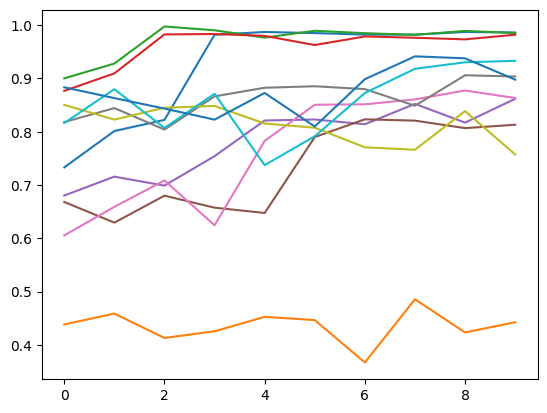

In [8]:
tmp = pd.read_csv('./Generalization_inter_subject.csv')
plt.plot(tmp)
plt.show()

# Few-shot adaptation

In [6]:
def Few_shot_Learning(K):
    path_abnormal = "../../../Data/Gait1/Abnormal/"
    path_normal = "../../../Data/Gait1/normal/"

    lst_abnormal = os.listdir(path_abnormal)
    lst_normal = os.listdir(path_normal)

    window_size, step_size = 200, 10
    num_channels, num_features = 5, 5  # we extracted 5 features per channel

    subjects_data, subjects_label = data_setup(lst_normal, path_normal, window_size, step_size)
    ACC_all_before, ACC_all_after = [], []


    for subject_id in subjects_data.keys():
        print(f"Sub ID {subject_id}")
        X, y = get_X_y(X=subjects_data[subject_id], y=subjects_label[subject_id])
        X = X.reshape(-1, num_channels, num_features, 1)

        Sub_acc_before, Sub_acc_after = [], []

        for subject_id_target in subjects_data.keys():
            if subject_id == subject_id_target:
                pass
            else:
                model = Model.build_model(input_shape=X.shape[1:], num_classes=len(np.unique(y)))
                history = model.fit(X, y, epochs=50, batch_size=64, verbose=0)
                meta = Adaptation.MetaLearner(input_model=model, N_way=len(np.unique(y)), input_shape=X.shape[1:],
                    meta_iters=5,                              # Number of meta-training loops
                    meta_step_size=2                          # Reptile meta step
                )

                X_target, y_target = get_X_y(X=subjects_data[subject_id_target], y=subjects_label[subject_id_target])
                X_target = X_target.reshape(-1, num_channels, num_features, 1)
                X_train_meta, X_test, y_train_meta, y_test = train_test_split(X_target, y_target, test_size=0.2, random_state=42)

                loss, acc_before = model.evaluate(X_test, y_test, verbose=0)

                #Meta adaptation
                acc_after = meta.train(X_train_meta, y_train_meta, X_test, y_test, Adaptation.get_data_Meta, N_way=len(np.unique(y)), K_shot=K)
                #loss, acc_after = model.evaluate(X_test, y_test, verbose=0)

                #Visualization.learning_plot(history)
                print(f"\t Target sub {subject_id_target} acc => before: {acc_before*100:.2f}% | after: {acc_after*100:.2f}%")
                Sub_acc_before.append(acc_before)
                Sub_acc_after.append(acc_after)

        ACC_all_before.append(Sub_acc_before)
        ACC_all_after.append(Sub_acc_after)
        print("\n")

    subs = ["S10", "S11", "S1", "S2","S3","S4","S5","S6","S7","S8","S9"]
    pd.DataFrame(np.array(ACC_all_before).T, columns=subs).to_csv(f"./Generalization_inter_subject_BEFORE_adaptation_K{K}.csv", index=False)
    pd.DataFrame(np.array(ACC_all_after).T, columns=subs).to_csv(f"./Generalization_inter_subject_AFTER_adaptation_K{K}.csv", index=False)


In [3]:
Few_shot_Learning(K=10)

Sub ID 10
	 Target sub 11 acc => before: 59.67% | after: 88.28%
	 Target sub 1 acc => before: 89.13% | after: 93.42%
	 Target sub 2 acc => before: 91.54% | after: 93.45%
	 Target sub 3 acc => before: 67.18% | after: 75.73%
	 Target sub 4 acc => before: 52.34% | after: 74.31%
	 Target sub 5 acc => before: 55.54% | after: 83.60%
	 Target sub 6 acc => before: 68.42% | after: 77.89%
	 Target sub 7 acc => before: 85.43% | after: 93.59%
	 Target sub 8 acc => before: 72.24% | after: 87.10%
	 Target sub 9 acc => before: 82.58% | after: 97.85%


Sub ID 11
	 Target sub 10 acc => before: 74.09% | after: 99.30%
	 Target sub 1 acc => before: 61.80% | after: 90.84%
	 Target sub 2 acc => before: 72.17% | after: 94.13%
	 Target sub 3 acc => before: 47.48% | after: 78.17%
	 Target sub 4 acc => before: 40.93% | after: 68.68%
	 Target sub 5 acc => before: 55.40% | after: 77.99%
	 Target sub 6 acc => before: 47.02% | after: 69.47%
	 Target sub 7 acc => before: 71.41% | after: 92.72%
	 Target sub 8 acc => 

In [7]:
Few_shot_Learning(K=2)

Sub ID 10
	 Target sub 11 acc => before: 46.88% | after: 81.74%
	 Target sub 1 acc => before: 87.98% | after: 85.69%
	 Target sub 2 acc => before: 90.31% | after: 91.13%
	 Target sub 3 acc => before: 69.31% | after: 83.21%
	 Target sub 4 acc => before: 57.97% | after: 65.11%
	 Target sub 5 acc => before: 62.59% | after: 78.27%
	 Target sub 6 acc => before: 80.82% | after: 87.49%
	 Target sub 7 acc => before: 71.41% | after: 89.24%
	 Target sub 8 acc => before: 68.72% | after: 80.55%
	 Target sub 9 acc => before: 85.55% | after: 87.70%


Sub ID 11
	 Target sub 10 acc => before: 77.17% | after: 95.45%
	 Target sub 1 acc => before: 57.22% | after: 82.26%
	 Target sub 2 acc => before: 61.66% | after: 85.27%
	 Target sub 3 acc => before: 63.05% | after: 77.71%
	 Target sub 4 acc => before: 40.80% | after: 70.74%
	 Target sub 5 acc => before: 51.22% | after: 64.60%
	 Target sub 6 acc => before: 58.25% | after: 88.54%
	 Target sub 7 acc => before: 85.33% | after: 93.37%
	 Target sub 8 acc => 

In [8]:
Few_shot_Learning(K=5)

Sub ID 10
	 Target sub 11 acc => before: 44.60% | after: 80.37%
	 Target sub 1 acc => before: 90.70% | after: 89.13%
	 Target sub 2 acc => before: 84.31% | after: 95.50%
	 Target sub 3 acc => before: 63.21% | after: 74.81%
	 Target sub 4 acc => before: 60.85% | after: 74.86%
	 Target sub 5 acc => before: 57.41% | after: 84.17%
	 Target sub 6 acc => before: 76.96% | after: 89.47%
	 Target sub 7 acc => before: 80.33% | after: 89.57%
	 Target sub 8 acc => before: 73.41% | after: 78.30%
	 Target sub 9 acc => before: 75.20% | after: 88.42%


Sub ID 11
	 Target sub 10 acc => before: 78.43% | after: 93.35%
	 Target sub 1 acc => before: 66.81% | after: 88.41%
	 Target sub 2 acc => before: 65.89% | after: 85.81%
	 Target sub 3 acc => before: 50.23% | after: 74.35%
	 Target sub 4 acc => before: 43.68% | after: 64.97%
	 Target sub 5 acc => before: 53.38% | after: 76.69%
	 Target sub 6 acc => before: 47.02% | after: 79.30%
	 Target sub 7 acc => before: 58.37% | after: 95.76%
	 Target sub 8 acc => 

In [9]:
Few_shot_Learning(K=20)

Sub ID 10
	 Target sub 11 acc => before: 58.60% | after: 94.37%
	 Target sub 1 acc => before: 90.27% | after: 99.28%
	 Target sub 2 acc => before: 88.40% | after: 96.86%
	 Target sub 3 acc => before: 65.19% | after: 78.78%
	 Target sub 4 acc => before: 53.98% | after: 73.49%
	 Target sub 5 acc => before: 59.71% | after: 93.67%
	 Target sub 6 acc => before: 79.18% | after: 94.39%
	 Target sub 7 acc => before: 78.70% | after: 94.24%
	 Target sub 8 acc => before: 83.87% | after: 92.86%
	 Target sub 9 acc => before: 88.32% | after: 97.44%


Sub ID 11
	 Target sub 10 acc => before: 78.50% | after: 98.81%
	 Target sub 1 acc => before: 58.37% | after: 94.42%
	 Target sub 2 acc => before: 71.08% | after: 92.22%
	 Target sub 3 acc => before: 39.85% | after: 82.90%
	 Target sub 4 acc => before: 39.56% | after: 71.29%
	 Target sub 5 acc => before: 43.02% | after: 91.51%
	 Target sub 6 acc => before: 70.64% | after: 89.59%
	 Target sub 7 acc => before: 73.91% | after: 99.89%
	 Target sub 8 acc => 

In [10]:
Few_shot_Learning(K=1)

Sub ID 10
	 Target sub 11 acc => before: 44.29% | after: 75.49%
	 Target sub 1 acc => before: 87.84% | after: 89.70%
	 Target sub 2 acc => before: 91.00% | after: 92.22%
	 Target sub 3 acc => before: 63.36% | after: 73.59%
	 Target sub 4 acc => before: 57.83% | after: 72.39%
	 Target sub 5 acc => before: 58.13% | after: 69.78%
	 Target sub 6 acc => before: 75.79% | after: 78.83%
	 Target sub 7 acc => before: 83.37% | after: 88.15%
	 Target sub 8 acc => before: 81.04% | after: 79.57%
	 Target sub 9 acc => before: 83.91% | after: 82.27%


Sub ID 11
	 Target sub 10 acc => before: 72.34% | after: 79.62%
	 Target sub 1 acc => before: 71.24% | after: 79.40%
	 Target sub 2 acc => before: 70.12% | after: 75.58%
	 Target sub 3 acc => before: 40.61% | after: 67.48%
	 Target sub 4 acc => before: 43.41% | after: 54.81%
	 Target sub 5 acc => before: 41.44% | after: 61.58%
	 Target sub 6 acc => before: 69.82% | after: 76.37%
	 Target sub 7 acc => before: 66.96% | after: 83.15%
	 Target sub 8 acc => 